# GMM

Here we'll explore Gaussian mixture models, which is an unsupervised clustering and density estimation technique. We previously saw an example of k-means, which is a clustering algorithm, which is most often fit using an expectation-maximization approach. Here we'll consider an extension to this which is suitable for both clustering and density estimation.
First, let's generate some one-dimensional data in a particular distribution. We will then explore how GMMs can be applied to estimate its density and detect outliers.

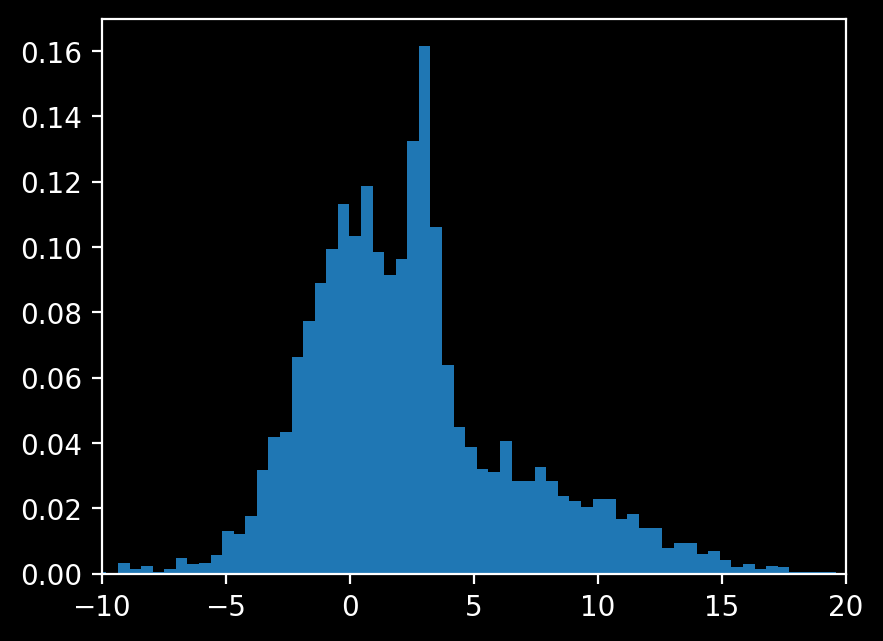

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
x = np.concatenate([
    np.random.normal(0, 2, 2000),
    np.random.normal(5, 5, 2000),
    np.random.normal(3, 0.5, 600)
])
plt.hist(x, 80, density=True)
plt.xlim(-10, 20);

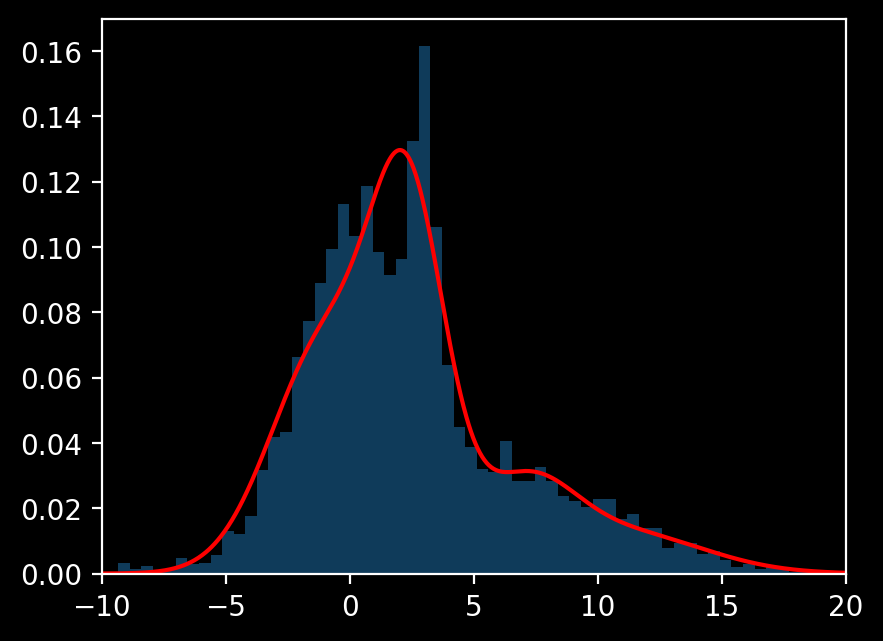

In [3]:
from sklearn.mixture import GaussianMixture as GMM
X = x[:, np.newaxis]
# Fit the model:
clf = GMM(4, max_iter=500, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])
# Plot the data and density:
plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit not as a single Gaussian, but using a mixture of Gaussians. Next, we will examine its individual components.

In [4]:
print(f'Means = {clf.means_}')
print(f'\nCovariances = {clf.covariances_}')
print(f'\nWeights = {clf.weights_}')

Means = [[ 2.3930921 ]
 [11.08960533]
 [-0.92546383]
 [ 7.02808953]]

Covariances = [[[ 2.24902207]]

 [[10.099018  ]]

 [[ 4.98083492]]

 [[ 3.87429382]]]

Weights = [0.38339489 0.09847354 0.39509906 0.12303252]


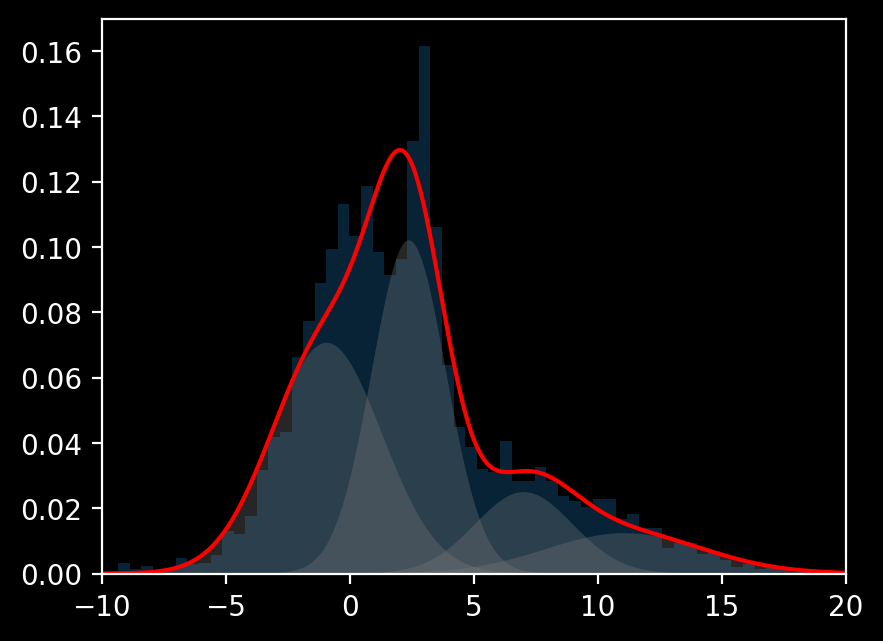

In [5]:
from scipy import stats
plt.hist(x, 80, density=True, alpha=0.3)
plt.plot(xpdf, density, '-r')
for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0], np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray', edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

The density approximated with GMMs is a mixture of four Gaussians — let's plot them as components of the approximated density on top of the data.

These individual Gaussian distributions are fit using an expectation-maximization method, much as in k-means, except that rather than explicit cluster assignment, the posterior probability is used to compute the weighted mean and covariance. Somewhat surprisingly, this algorithm provably converges to the optimum (though the optimum is not necessarily global).

# How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data. For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC):


In [6]:
print(clf.bic(X))
print(clf.aic(X))

25963.88685202711
25893.114924619862


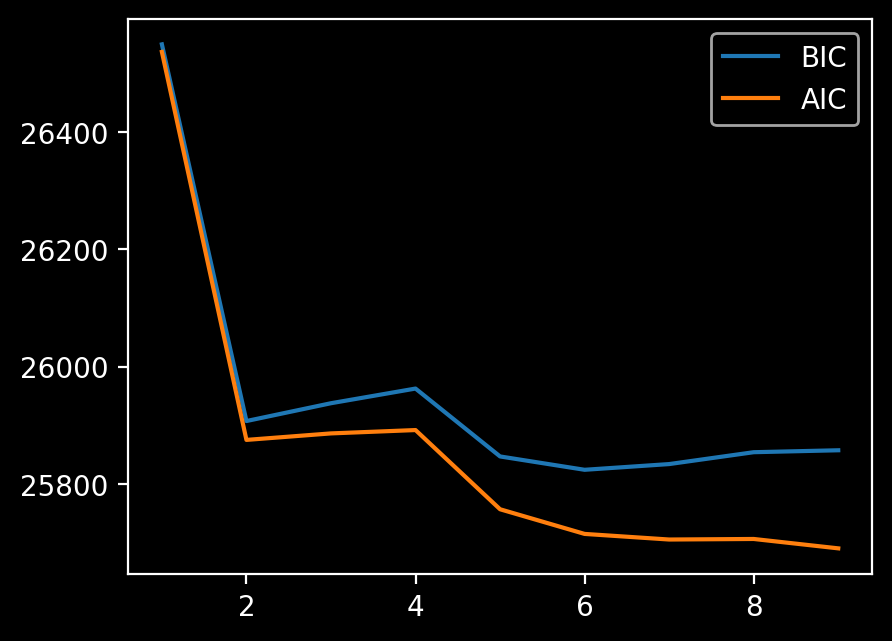

In [7]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, max_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]
plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred.

# Other density estimators
The other main density estimator that you might find useful is Kernel Density Estimation, which is available via sklearn.neighbors.KernelDensity. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of every training point!


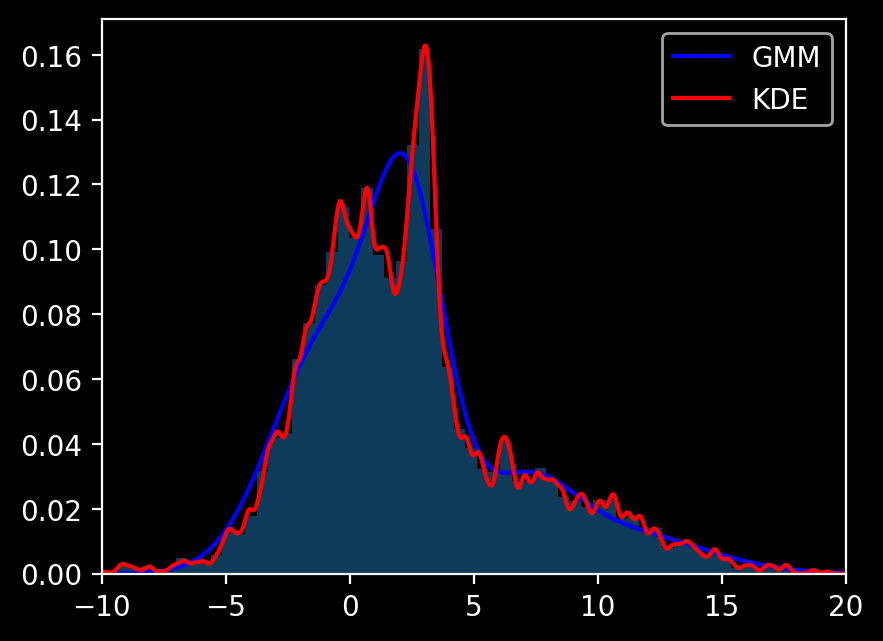

In [8]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))
plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as generative models of the data: that is, the model tells us how more data can be created which fits the model.

# Preparing data

GMM is what's known as a generative model: it's a probabilistic model from which a dataset can be generated. One thing that generative models can be useful for is outlier detection: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeled outliers.

Let's take a look at this by introducing outliers to our dataset:
    

In [9]:
np.random.seed(0)
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)
print(f'Introduced outliers with indices: {true_outliers}')

Introduced outliers with indices: [  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]


We have randomly selected 20 samples from our dataset and updated their values, so that they would seem like outliers. Next, we will try to identify them using GMMs.

We will now fit a Gaussian mixture model on our updated dataset, and will plot model's score on top of the data. This score is the per-sample average log-likelihood, or, effectively, the probability of a particular value appearing in our data

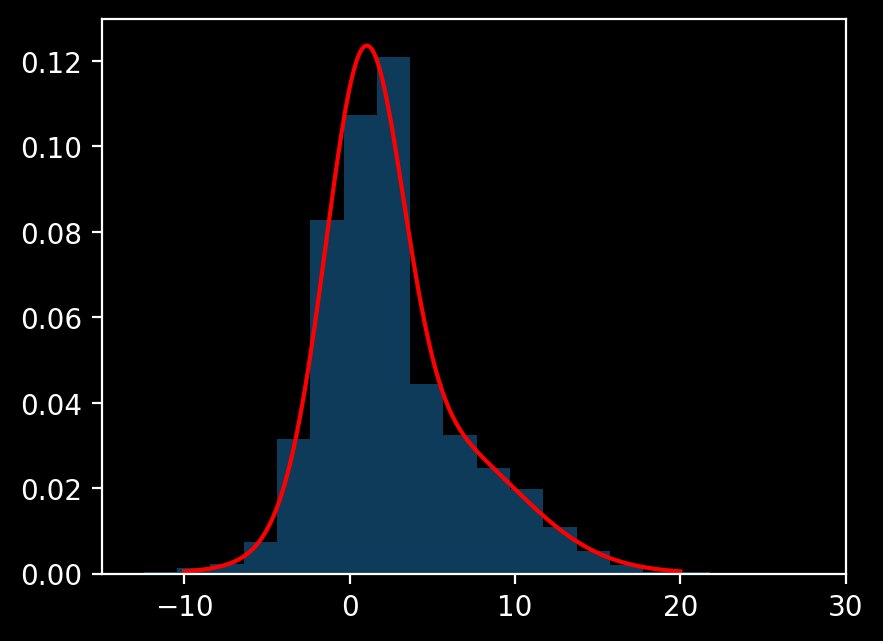

In [10]:
clf = GMM(4, max_iter=500, random_state=0).fit(y[:, np.newaxis])
density_noise = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])
plt.hist(y, 80, density=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of y:

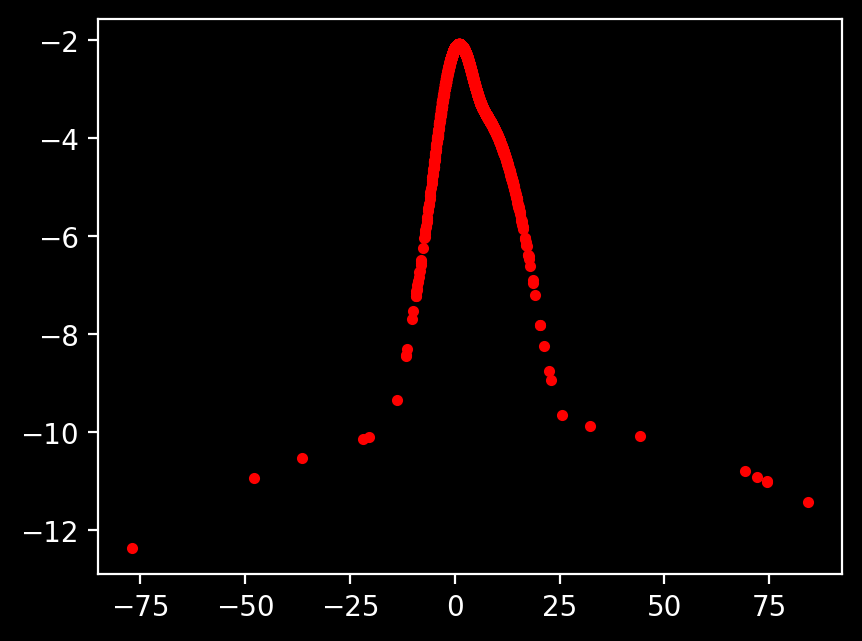

In [11]:
log_likelihood = np.array([clf.score_samples([[yy]]) for yy in y])
plt.plot(y, log_likelihood, '.r');

Looks like a few points have low log-likelihood, we should be able to use this for outlier detection

# identifiying outliers

We can now label the points with a suitably low likelihood as outliers. Mind, that "suitable" is up to our own bias/variance preference — here we will use -9 as a cut-off point.


In [12]:
detected_outliers = np.where(log_likelihood < -9)[0]
print(f"True outliers: {true_outliers}")
print(f"\nDetected outliers: {detected_outliers}")

True outliers: [  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

Detected outliers: [  99  537  705 1653 2046 2135 2163 2496 2732 2893 2897 3067 3468 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)
Here are the outliers that were missed:

In [13]:
set(true_outliers) - set(detected_outliers)

{1033, 1701, 1871, 2222, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [14]:
set(detected_outliers) - set(true_outliers)

{3067}